In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import create_engine, func, MetaData
from sqlalchemy import inspect, Table, select
from sqlalchemy import desc

# Import the dependencies.
from sqlalchemy import Column, Integer, String, Float

# Reflect Tables into SQLAlchemy ORM

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [4]:
# Statements needed to identify all tables and all columns within tables of the sqlite db
# https://bootcampspot.instructure.com/courses/4981/external_tools/313

# Create MetaData object
metadata = MetaData()

# Reflect database tables into MetaData
metadata.reflect(bind=engine)

In [5]:
# reflect existing database into new model
Base = automap_base()

# reflect tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Statements needed to identify table and column names in sqlite db
# https://bootcampspot.instructure.com/courses/4981/external_tools/313

# Create an inspector
inspector = inspect(engine)

# Get a list of table names in the database
table_names = inspector.get_table_names()

# Iterate over the tables and print table name and its columns
for table_name in table_names:
    table = metadata.tables[table_name]
    print(f"Table: {table_name}")
    for column in table.columns:
        print(f"  Column: {column.name}")   

Table: measurement
  Column: id
  Column: station
  Column: date
  Column: prcp
  Column: tobs
Table: station
  Column: id
  Column: station
  Column: name
  Column: latitude
  Column: longitude
  Column: elevation


In [8]:
#Get primary and foreign key information from each table
#https://bootcampspot.instructure.com/courses/4981/external_tools/313 provided correct syntax
primary_keys = inspector.get_pk_constraint('measurement')
print(primary_keys['constrained_columns'])    
    
primary_keys = inspector.get_pk_constraint('station')
print(primary_keys['constrained_columns']) 

['id']
['id']


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create session (link) from Python to DB
# Create Session Object to Connect to DB
Session = sessionmaker(bind=engine)
session = Session()

# Exploratory Precipitation Analysis

In [11]:
# 'session' object is bound to engine
# Query to count the rows in Measurement table
row_count = session.query(func.count(Measurement.id)).scalar()

print(f"Number of rows in Measurement table: {row_count}")

#session.query() creates query object
#.scalar() executes query and returns count as scalar value

Number of rows in Measurement table: 19550


In [12]:
# Find the most recent date in the data set.
# https://bootcampspot.instructure.com/courses/4981/external_tools/313 provided correct syntax

# 1. Create select statement to find most recent date using Measurement class
# Call all date values from database
date_values = session.query(Measurement.date).all()

# 2. Create query to find maximum (most recent) date in Measurement table 
# func.max() function calculates maximum date value, and .label('most_recent_date') assigns label to result
stmt = session.query(func.max(Measurement.date).label('most_recent_date'))

# 3. Execute query and fetch result
# Line executes query within session context and fetches scalar result (most recent date from Measurement table)
most_recent_measurement_date = stmt.scalar()
print("Most Recent Measurement Date:", most_recent_measurement_date)

# Executing a SQLalchemy query using scalar() method returns single value from first column of first row of result set 
# Using scalar() on a query that returns a single value (such as an aggregate function), is a convenient way to retrieve that single value directly without having to deal with tuples or rows of data.

Most Recent Measurement Date: 2017-08-23


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Assistance provided by https://bootcampspot.instructure.com/courses/4981/external_tools/313

# 1.Calculate the date one year from the last date in data set.
# a. Calculate maximum date
max_date_str = session.query(func.max(Measurement.date)).scalar()
# b. Convert string date to datetime object before applying timedelta operation
max_date_obj = dt.datetime.strptime(max_date_str, '%Y-%m-%d')
# b.Subtract timedelta object from datetime object to find date one year ago
one_year_ago = max_date_obj - timedelta(days=365)
print("Date 1 Year Ago:", one_year_ago)

# 2. Perform a query to retrieve the data and precipitation scores
# all() retrieves all query results as list of tuples 
last_12_months_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= max_date_obj - timedelta(days=365)).all()

#Count and print number of rows returned by query
num_rows = len(last_12_months_data)
print("Number of rows returned by the query:", num_rows)

Date 1 Year Ago: 2016-08-23 00:00:00
Number of rows returned by the query: 2223


In [14]:
# 3. Save the query results as a Pandas DataFrame. Explicitly set the column names
# a. Convert 'None' to 0.0 for days with no precipitation
# Assistance provided by https://bootcampspot.instructure.com/courses/4981/external_tools/313
last_12_months_data_fixed = [(date, 0.0 if value is None else value) for date, value in last_12_months_data]
#print(last_12_months_data_fixed)
len(last_12_months_data_fixed)
# b. Extract date and precipitation values from query result into lists
date = []
precipitation = []
date = [result[0] for result in last_12_months_data_fixed]
precipitation = [result[1] for result in last_12_months_data_fixed]

#c. Convert list to dictionary because Pandas requires data in dictionary format for easy conversion into DataFrame
dataframe = pd.DataFrame({'Date': date, 'Precipitation': precipitation})

#4. Sort the dataframe by date
#Use sort_values() function in Pandas
dataframe_sorted = dataframe.sort_values('Date')

print(dataframe_sorted)

            Date  Precipitation
0     2016-08-24           0.08
1006  2016-08-24           0.00
1524  2016-08-24           2.15
702   2016-08-24           2.28
360   2016-08-24           2.15
...          ...            ...
1522  2017-08-22           0.00
1523  2017-08-23           0.08
359   2017-08-23           0.00
1005  2017-08-23           0.00
2222  2017-08-23           0.45

[2223 rows x 2 columns]


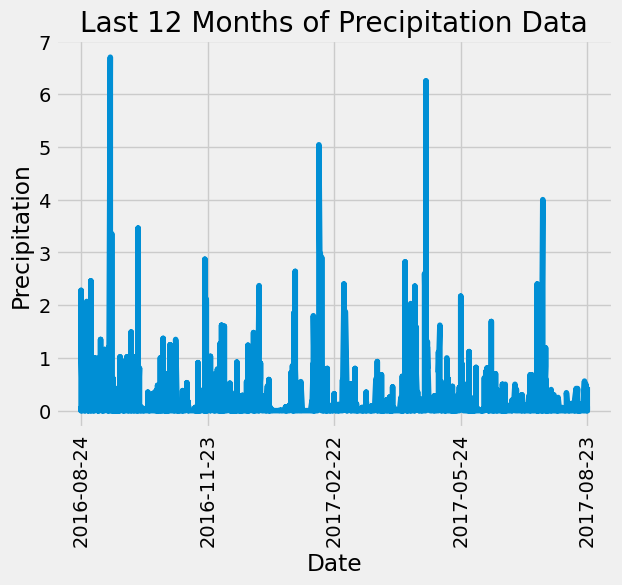

In [15]:
#5. Use Pandas Plotting with Matplotlib to plot the data
plot_dataframe_sorted = pd.DataFrame(dataframe_sorted)

# a.Create plot
plt.plot(plot_dataframe_sorted['Date'], plot_dataframe_sorted['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Last 12 Months of Precipitation Data')

# b. Rotate x-axis tick marks by 90 degrees
plt.xticks(rotation=90)

# c. Calculate indices for 5 equally spaced tick marks
# assistance provided by https://bootcampspot.instructure.com/courses/4981/external_tools/3   
num_ticks = 5
tick_indices = np.linspace(0, 364, num_ticks, dtype=int)

# d. Set x-axis tick positions using calculated indices
plt.xticks(tick_indices)

# e. Show plot
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data

# Calculate summary statistics using describe()
summary_stats = dataframe_sorted.describe()
print(summary_stats)

       Precipitation
count    2223.000000
mean        0.159951
std         0.441220
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max         6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset

# Count unique values in 'station' column of 'Station' table
# 1. Construct query to count distinct stations
query = select(func.count(func.distinct(Station.station)))

# 2. Execute query and fetch results
distinct_station_count = session.execute(query).scalar()

print(distinct_station_count)

9


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Count number of instances a unique value of 'station' appears in Measurements table:
counts_by_station = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print(counts_by_station)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Assistance provided by https://bootcampspot.instructure.com/courses/4981/external_tools/313

#1. Identify most active station 
#a. Convert 'counts_by_station' list of tuples to dictionary with keys as [0] element and values as [1] element
counts_by_station_dict = {key: value for key, value in counts_by_station}
print(counts_by_station_dict)

# Dictionary comprehension {key: value for key, value in data} unpacks tuples 
# list and uses [0] element as key and [1] element as value when creating dictionary

# In counts_by_station_dict = {key: value for key, value in counts_by_station}, Python using iterable 
# unpacking to assign elements of each tuple in counts_by_station list to key and value
# For each tuple in counts_by_station list, unpacking assigns first element of tuple to key and second element to value

# Dictionary comprehension then creates dictionary where keys are taken from key variable and values are taken from value variable

{'USC00519281': 2772, 'USC00519397': 2724, 'USC00513117': 2709, 'USC00519523': 2669, 'USC00516128': 2612, 'USC00514830': 2202, 'USC00511918': 1979, 'USC00517948': 1372, 'USC00518838': 511}


In [20]:
#(continued)

# b. Find station in counts_by_station_dict with highest count value
station_with_highest_count = max(counts_by_station_dict, key=counts_by_station_dict.get)
# key=counts_by_station_dict.get specifies that max comparison should be based on values in dictionary, not keys

print(station_with_highest_count)

USC00519281


In [21]:
#(continued)

#2. Calculate maximum date and most recent 12 months of dates
max_date_str = session.query(func.max(Measurement.date)).scalar()
max_date_obj = dt.datetime.strptime(max_date_str, '%Y-%m-%d')

#3. Query for all past 12 months tobs from most active station
last_12_months_active_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= max_date_obj - timedelta(days=365)).filter(Measurement.station == station_with_highest_count).all()

# 4. Extract float values from tuples and apply min, max, mean functions
temperatures = [tup[1] for tup in last_12_months_active_tobs]
min_value = min(temperatures)
max_value = max(temperatures)
mean_value = sum(temperatures) / len(temperatures)

print("Min:", min_value)
print("Max:", max_value)
print("Mean:", mean_value)

Min: 59.0
Max: 83.0
Mean: 73.0968660968661


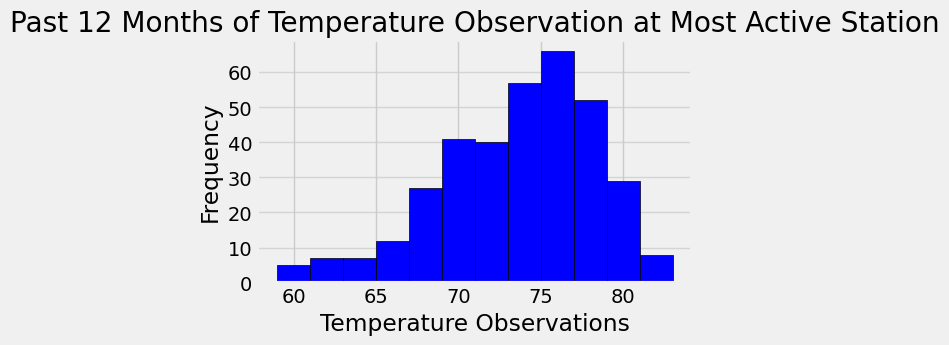

In [22]:
# Using the most active station id, query last 12 months of tobs data for this station and plot the results as a histogram
# Assistance provided by https://bootcampspot.instructure.com/courses/4981/external_tools/313
                   
# Part 1. 
#a. Query for most active station id and most recent 12 months of tobs for it
last_12_months_active_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= (max_date_obj - timedelta(days=365)), Measurement.station == station_with_highest_count).all()

#b. Convert 'None' to 0.0 for days with no tobs measurement
last_12_months_active_tobs_fixed = [(date, 0.0 if tobs is None else tobs) for date, tobs in last_12_months_active_tobs]
    
#c. Convert query results to list of dictionaries
last12activetobs_list = []
for row in last_12_months_active_tobs_fixed:
    data_dict = {'date': row[0],'temperature': row[1]}
    last12activetobs_list.append(data_dict) 
#print(last12activetobs_list)

#Part 2
#a. Extract temperature observations from 'last12activetobs_list'
#temp_obs = [result[1] for result in last12activetobs_list]
temp_obs = [result['temperature'] for result in last12activetobs_list]

#b. Plot histogram
plt.figure(figsize=(5, 3))
plt.hist(temp_obs, bins=12, color='blue', edgecolor='black')
plt.xlabel('Temperature Observations')
plt.ylabel('Frequency')
plt.title('Past 12 Months of Temperature Observation at Most Active Station')
plt.grid(axis='y', alpha=0.75)
plt.yticks(range(0, 60 + 10, 10))  # Customize y-axis ticks
plt.show()

# Close Session

In [23]:
# Close Session
session.close()